# Selecting Characteristics in Generated Images

# 1. The Eye Glasses Dataset

## 1.1 Download the Dataset
The eyeglasses dataset we use is from Kaggle. Log into Kaggle and go to the link https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses/data to download the image folder and the two CSV files on the right: train.csv and test.csv. There are 5000 images in the folder /faces-spring-2020/. Once you have the data, place both the image folder and the two CSV files inside /Desktop/dgai/files/ on your computer.

In [39]:
# install pandas in a code cell !pip install pandas
import pandas as pd

train=pd.read_csv('./data/glasses-or-no-glasses/train.csv')
train.set_index('id', inplace=True)

In [40]:
print(train["glasses"])

id
1       0
2       1
3       1
4       0
5       0
       ..
4496    0
4497    0
4498    1
4499    1
4500    0
Name: glasses, Length: 4500, dtype: int64


In [41]:
import os, shutil

G='files/glasses/G/'
NoG='files/glasses/NoG/'
os.makedirs(G, exist_ok=True)    #A
os.makedirs(NoG, exist_ok=True)    #B
folder='data/glasses-or-no-glasses/faces-spring-2020/'
for i in range(1,4501):
    oldpath=f"{folder}face-{i}.png"
    if train.loc[i]['glasses']==0:    #C
        newpath=f"{NoG}face-{i}.png"
    elif train.loc[i]['glasses']==1:    #D
        newpath=f"{G}face-{i}.png"
    try:
        shutil.move(oldpath, newpath)
    except:
        pass

## 1.2 Visualize images in the eyeglasses dataset

## important: make sure you do this:
The classification column *glasses* in the file *train.csv* is not perfect. If you go to the subfolder G on your computer, for example, you'll see that most images have glasses, but about 10% of them have no glasses. Similarly, if you go to the subfolder NoG, you'll see that about 10% of them actually have glasses. You need to manually correct this by moving images from one folder to the other. This is important for our training later so you should do the same: manually move images in the two folders so that one contains only images with glasses and the other images without glasses. Welcome to the life of a data scientist: fixing data problems is part of daily routine!

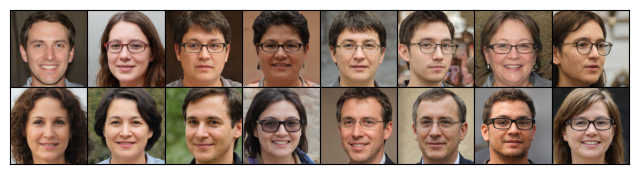

In [42]:
import random
import matplotlib.pyplot as plt
from PIL import Image

imgs=os.listdir(G)
random.seed(42)
samples=random.sample(imgs,16)
fig=plt.figure(dpi=100, figsize=(8,2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img=Image.open(f"{G}{samples[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)
plt.show()   

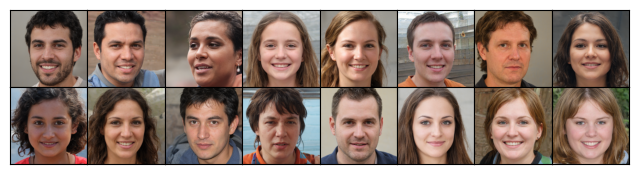

In [43]:
random.seed(42)
imgs=os.listdir(NoG)
samples=random.sample(imgs,16)
fig=plt.figure(dpi=100, figsize=(8,2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img=Image.open(f"{NoG}{samples[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)
plt.show()  

# 2. Conditional GAN wtih Wasserstein Distance


# 3. Create a conditional GAN
## 3.1. A Critic in Conditional GAN


In [44]:
import torch.nn as nn
import torch
print(torch.__version__)


# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
class Critic(nn.Module):
    def __init__(self, img_channels, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features, 
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features, features * 2, 4, 2, 1),
            self.block(features * 2, features * 4, 4, 2, 1),
            self.block(features * 4, features * 8, 4, 2, 1),
            self.block(features * 8, features * 16, 4, 2, 1),  
            self.block(features * 16, features * 32, 4, 2, 1),            
            nn.Conv2d(features * 32, 1, kernel_size=4,
                      stride=2, padding=0))
    def block(self, in_channels, out_channels, 
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,
                kernel_size,stride,padding,bias=False,),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2))
    def forward(self, x):
        return self.net(x)

2.7.0+cu126


## 3.2. The Generator in Conditional GAN


In [45]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(noise_channels, features *64, 4, 1, 0),
            self.block(features * 64, features * 32, 4, 2, 1),
            self.block(features * 32, features * 16, 4, 2, 1),
            self.block(features * 16, features * 8, 4, 2, 1),
            self.block(features * 8, features * 4, 4, 2, 1),            
            self.block(features * 4, features * 2, 4, 2, 1),            
            nn.ConvTranspose2d(
                features * 2, img_channels, kernel_size=4,
                stride=2, padding=1),
            nn.Tanh())
    def block(self, in_channels, out_channels, 
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,
                kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),)
    def forward(self, x):
        return self.net(x)

## 3.3 Weight initialization and the gradient penalty function

In [46]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [47]:
z_dim=100
img_channels=3
features=16
gen=Generator(z_dim+2,img_channels,features).to(device)
critic=Critic(img_channels+2,features).to(device)
weights_init(gen)
weights_init(critic)

In [48]:
lr = 0.0001
opt_gen = torch.optim.Adam(gen.parameters(), 
                         lr = lr, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), 
                         lr = lr, betas=(0.0, 0.9))

In [49]:
def GP(critic, real, fake):
    B, C, H, W = real.shape
    alpha=torch.rand((B,1,1,1)).repeat(1,C,H,W).to(device)
    interpolated_images = real*alpha+fake*(1-alpha)
    critic_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=critic_scores,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True)[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

# 4. Train the conditional GAN


## 4.1. Adding labels


In [50]:
import torchvision.transforms as T
import torchvision

batch_size=16
imgsz=256
transform=T.Compose([
    T.Resize((imgsz,imgsz)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])      
data_set=torchvision.datasets.ImageFolder(
    root=r"files/glasses",
    transform=transform) 

In [51]:
newdata=[]
for i,(img,label) in enumerate(data_set):
    onehot=torch.zeros((2))
    onehot[label]=1
    channels=torch.zeros((2,imgsz,imgsz))
    if label==0:
        channels[0,:,:]=1
    else:
        channels[1,:,:]=1    
    img_and_label=torch.cat([img,channels],dim=0)    
    newdata.append((img,label,onehot,img_and_label))

In [52]:
data_loader=torch.utils.data.DataLoader(
    newdata,batch_size=batch_size,shuffle=True)

## 4.2	Train the Conditional GAN


In [ ]:
def plot_epoch(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [1,0] so G knows what to generate
    labels[:,0,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(10,5),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/G{epoch}.png")
    if (epoch-1) % 10 == 0:
        plt.show() 
    # test images without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [0,1] so G knows what to generate
    labels[:,1,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(10,5),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/NoG{epoch}.png")
    if (epoch-1) % 10 == 0:
        plt.show()

In [54]:
def train_batch(onehots,img_and_labels,epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B, z_dim, 1, 1)
        onehots=onehots.reshape(B,2,1,1)
        noise_and_labels=torch.cat([noise,onehots],dim=1).to(device)
        fake_img = gen(noise_and_labels).to(device)
        fakelabels=img_and_labels[:,3:,:,:].to(device)
        fake=torch.cat([fake_img,fakelabels],dim=1).to(device)
        critic_real = critic(real).reshape(-1)
        critic_fake = critic(fake).reshape(-1)
        gp = GP(critic, real, fake)
        loss_critic = (-(torch.mean(critic_real) - 
           torch.mean(critic_fake)) + 10 * gp)
        opt_critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
    # train G
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return loss_critic, loss_gen

In [ ]:
for epoch in range(1,101):
    closs=0
    gloss=0
    for _,_,onehots,img_and_labels in data_loader:    
        # train a batch
        loss_critic, loss_gen = train_batch(onehots,\
                                img_and_labels,epoch)   
        closs+=loss_critic.detach()/len(data_loader)
        gloss+=loss_gen.detach()/len(data_loader)
    print(f"at epoch {epoch},\
    critic loss: {closs}, generator loss {gloss}")
    plot_epoch(epoch)
torch.save(gen.state_dict(),'files/cgan.pth')

at epoch 1,    critic loss: -71.43391418457031, generator loss 325.5628356933594


# 5. Select characteristics in generated images


## 5.1. Select images with or without eyeglasses


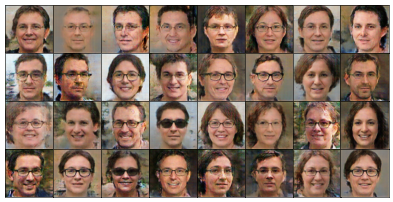

In [38]:
torch.manual_seed(0)

generator=Generator(z_dim+2,img_channels,features).to(device)
generator.load_state_dict(torch.load("files/cgan.pth",
                                    map_location=device))
generator.eval()

noise_g = torch.randn(32, z_dim, 1, 1)
labels_g = torch.zeros(32, 2, 1, 1)
labels_g[:,0,:,:]=1
noise_and_labels=torch.cat([noise_g,labels_g],dim=1).to(device)
fake=generator(noise_and_labels)
plt.figure(figsize=(10,5),dpi=50)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show() 

In [19]:
z_male_g=noise_g[0]
z_female_g=noise_g[14]

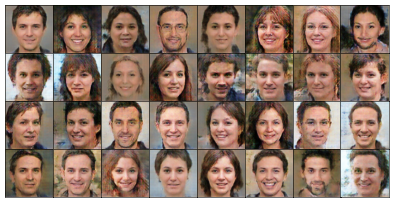

In [37]:
noise_ng = torch.randn(32, z_dim, 1, 1)
labels_ng = torch.zeros(32, 2, 1, 1)
labels_ng[:,1,:,:]=1
noise_and_labels=torch.cat([noise_ng,labels_ng],dim=1).to(device)
fake=generator(noise_and_labels).cpu().detach()
plt.figure(figsize=(10,5),dpi=50)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())#.repeat(4,axis=0).repeat(4,axis=1))
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

In [21]:
z_male_ng=noise_ng[8]
z_female_ng=noise_ng[31]

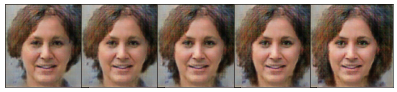

In [36]:
weights=[0,0.25,0.5,0.75,1]
plt.figure(figsize=(10,4),dpi=50)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # change the value of z
    label=weights[i]*labels_ng[0]+(1-weights[i])*labels_g[0]
    noise_and_labels=torch.cat(
        [z_female_g.reshape(1, z_dim, 1, 1),
         label.reshape(1, 2, 1, 1)],dim=1).to(device)    
    fake=generator(noise_and_labels).cpu().detach()    
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

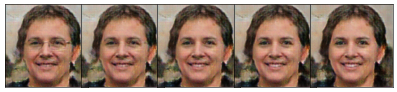

In [35]:
# solution to Exercise 5.1
weights=[0,0.25,0.5,0.75,1]
plt.figure(figsize=(10,4),dpi=50)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # change the value of z
    label=weights[i]*labels_ng[0]+(1-weights[i])*labels_g[0]
    noise_and_labels=torch.cat(
        [z_male_g.reshape(1, z_dim, 1, 1),
         label.reshape(1, 2, 1, 1)],dim=1).to(device)    
    fake=generator(noise_and_labels).cpu().detach()    
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

## 5.2 Vector arithmetic in latent space  

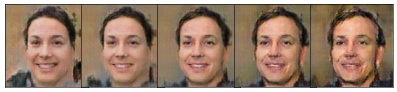

In [34]:
weights=[0,0.25,0.5,0.75,1]
plt.figure(figsize=(10,4),dpi=50)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # change the value of z
    z=weights[i]*z_female_ng+(1-weights[i])*z_male_ng
    noise_and_labels=torch.cat(
        [z.reshape(1, z_dim, 1, 1),
         labels_ng[0].reshape(1, 2, 1, 1)],dim=1).to(device)    
    fake=generator(noise_and_labels).cpu().detach()    
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

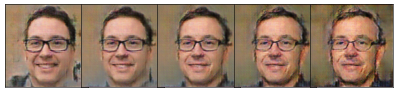

In [33]:
# solution to Exercise 5.2
weights=[0,0.25,0.5,0.75,1]
plt.figure(figsize=(10,4),dpi=50)
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # change the value of z
    z=weights[i]*z_female_ng+(1-weights[i])*z_male_ng
    noise_and_labels=torch.cat(
        [z.reshape(1, z_dim, 1, 1),
         labels_g[0].reshape(1, 2, 1, 1)],dim=1).to(device)    
    fake=generator(noise_and_labels).cpu().detach()    
    img=(fake[0]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

## Select two characteristic simultaneously

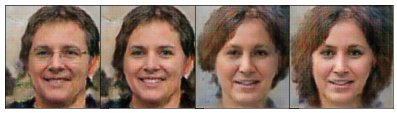

In [31]:
plt.figure(figsize=(10,5),dpi=50)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    p=i//2
    q=i%2 
    z=z_female_g*p+z_male_g*(1-p)
    label=labels_ng[0]*q+labels_g[0]*(1-q)
    noise_and_labels=torch.cat(
        [z.reshape(1, z_dim, 1, 1),
         label.reshape(1, 2, 1, 1)],dim=1).to(device)
    fake=generator(noise_and_labels)
    img=(fake.cpu().detach()[0]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

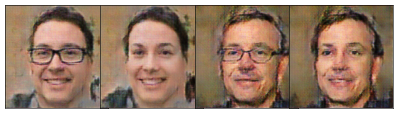

In [32]:
# solution to Exercise 5.3
plt.figure(figsize=(10,5),dpi=50)
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    p=i//2
    q=i%2 
    z=z_female_ng*p+z_male_ng*(1-p)
    label=labels_ng[0]*q+labels_g[0]*(1-q)
    noise_and_labels=torch.cat(
        [z.reshape(1, z_dim, 1, 1),
         label.reshape(1, 2, 1, 1)],dim=1).to(device)
    fake=generator(noise_and_labels)
    img=(fake.cpu().detach()[0]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

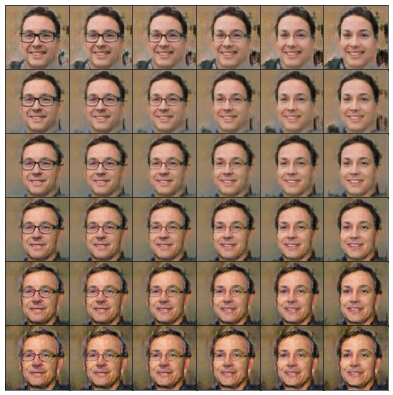

In [30]:
plt.figure(figsize=(10,10),dpi=50)
for i in range(36):
    ax = plt.subplot(6,6, i + 1)
    p=i//6
    q=i%6 
    z=z_female_ng*p/5+z_male_ng*(1-p/5)
    label=labels_ng[0]*q/5+labels_g[0]*(1-q/5)
    noise_and_labels=torch.cat(
        [z.reshape(1, z_dim, 1, 1),
         label.reshape(1, 2, 1, 1)],dim=1).to(device)
    fake=generator(noise_and_labels)
    img=(fake.cpu().detach()[0]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.08,hspace=-0.01)
plt.show()

In [ ]:
# solution to exercise 5.4
# note we changed z_dim+2 to z_dim+1
gen=Generator(z_dim+1,img_channels,features).to(device)
# note we changed img_channels+2 to img_channels+1
critic=Critic(img_channels+1,features).to(device)
weights_init(gen)
weights_init(critic)    
    
    
lr = 0.0001
opt_gen = torch.optim.Adam(gen.parameters(), 
                         lr = lr, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), 
                         lr = lr, betas=(0.0, 0.9))
# redefine the data iterator
newdata=[]
for i,(img,label) in enumerate(data_set):
    if label==0:
        # add just one channel; fill with 0s for glasses
        channels=torch.zeros((1,imgsz,imgsz))
    else:
        # add just one channel; fill with 1s for no glasses        
        channels=torch.ones((1,imgsz,imgsz))    
    img_and_label=torch.cat([img,channels],dim=0)    
    newdata.append((img,label,img_and_label))

data_loader=torch.utils.data.DataLoader(
    newdata,batch_size=batch_size,shuffle=True)

# label for g (with glasses); changed shape from (32,2,1,1) to (32,1,1,1)
labels_32g = torch.zeros(32, 1, 1, 1)
# label for ng (without glasses)
labels_32ng = torch.ones(32, 1, 1, 1)
def plot_epoch(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    noise_and_labels=torch.cat([noise,labels_32g],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/G{epoch}.png")
    if epoch % 10 == 0:
        plt.show() 
    # test images without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    noise_and_labels=torch.cat([noise,labels_32ng],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/glasses/NoG{epoch}.png")
    if epoch % 10 == 0:
        plt.show() 
    
    
def train_batch(label,img_and_labels,epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B,z_dim, 1, 1)
        label=label.reshape(B,1,1,1)
        noise_and_labels=torch.cat([noise,label],dim=1).to(device)
        fake_img = gen(noise_and_labels).to(device)
        fakelabels=img_and_labels[:,3:,:,:].to(device)
        fake=torch.cat([fake_img,fakelabels],dim=1).to(device)
        critic_real = critic(real).reshape(-1)
        critic_fake = critic(fake).reshape(-1)
        gp = GP(critic, real, fake)
        loss_critic=(-(torch.mean(critic_real) - 
           torch.mean(critic_fake)) + 10 * gp)
        opt_critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
    # train G
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return loss_critic, loss_gen    
    
for epoch in range(1,101):
    closs=0
    gloss=0
    for _,label,img_and_labels in data_loader:    
        # train a batch
        loss_critic, loss_gen = train_batch(label,\
                                img_and_labels,epoch)   
        closs+=loss_critic.detach()/len(data_loader)
        gloss+=loss_gen.detach()/len(data_loader)
    print(f"at epoch {epoch},\
    critic loss: {closs}, generator loss {gloss}")
    plot_epoch(epoch)
torch.save(gen.state_dict(),'files/cganbinary.pth')    